## Monocyte embedding 4 trajectory analysis

In [2]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

import torch
device = torch.device("cuda")

cwd = './Pan_fetal_immune/src/utils/'
sys.path.append(cwd)
import genes
import panfetal_utils

# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("split_name", 
#                     default="",
#                     help="ID for data split (e.g. NKT, Progenitors, Stroma...) (default: no split, full atlas)")
# args = parser.parse_args()
# spl = args.split_name

def load_data_split(data_dir, timestamp, split):
    # Load estimated gene dispersions for HVG selection
    # Generated running `Pan_fetal_immune/utils/PFI_pp_4_HVG_stats.py`
    adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)

    ### Load count data
    adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    adata_raw.var_names_make_unique()

    # Load obs
    new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)
    adata_raw.obs = new_obs.loc[adata_raw.obs_names]

    ## Load var
    adata_raw.var = adata_lognorm_var.copy()

    # ## Add batch key
    # adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]
    return(adata_raw)

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    exclude_genes = []
    if remove_cc_genes:
        exclude_genes.extend(genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        exclude_genes.extend(genes.IG_genes)
        exclude_genes.extend(genes.TCR_genes)
    
    adata = adata[:,~adata.var_names.isin(exclude_genes)]
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)

    ## Change gene names to ids
    adata.var_names = adata.var['GeneID'].values.copy()
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.model.SCVI.setup_anndata(adata, 
                                    categorical_covariate_keys = ["method", 'donor'], 
                                    copy=True)
    ## updated in new scArches version
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )
    vae = scvi.model.SCVI(adata, n_latent=n_dims, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )
    return(vae)

### Read full myeloid embedding

In [3]:
data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/"
figdir = '/home/jupyter/mount/gdrive/Pan_fetal/Updates_and_presentations/'
timestamp = "20210429"
adata_mye = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s="MYELOID_NEW"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata_mye.var_names_make_unique()

In [5]:
## Read annotation
obs = pd.read_csv('/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col=0)

/opt/conda/envs/ed6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
adata_mye.obs = obs.loc[adata_mye.obs_names].copy()
# adata_mye.obs

### Subset to monocytes

In [9]:
mono_annos = ['PROMONOCYTE', "MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"]
adata_mono = adata_mye[adata_mye.obs['anno_lvl_2_final_clean'].isin(mono_annos)].copy()

In [10]:
adata_mono

AnnData object with n_obs × n_vars = 41083 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean'
    var: 'GeneID', 'GeneName'

### Compute HVGs

In [11]:
adata_mono_lognorm = adata_mono.copy() 
sc.pp.normalize_per_cell(adata_mono_lognorm, counts_per_cell_after=10e4)
sc.pp.log1p(adata_mono_lognorm)
sc.pp.highly_variable_genes(adata_mono_lognorm, min_mean=0.001, max_mean=10, subset=False)

In [12]:
adata_mono.var = adata_mono_lognorm.var.copy()

### Prep 4 scVI

In [23]:
adata_mono = prep_scVI(adata_mono, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

### Train scVI

In [25]:
## Check feature selection
any(adata_mono.var_names.isin(genes.cc_genes))
any(adata_mono.var_names.isin(genes.TCR_genes))

False

In [26]:
vae = train_scVI(adata_mono, n_dims=10)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 41083 cells, 7500 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 2 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:37<00:00,  1.29s/it, loss=907, v_num=1]   


In [27]:
adata_mono.obsm["X_scVI"] = vae.get_latent_representation()
## Save embedding
outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.V2.npy".format(t=timestamp, s='MONOCYTES')
np.save(data_dir + outname, adata_mono.obsm["X_scVI"])

In [28]:
# save the reference model
model_dir = 'scvi_{s}_model/'.format(s='MONOCYTES')
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)

In [14]:
outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.V2.npy".format(t=timestamp, s='MONOCYTES')
adata_mono.obsm["X_scVI"] = np.load(data_dir + outname)

### Run KNN/UMAP/clustering 

In [15]:
adata_mono_lognorm.obsm['X_scvi'] = adata_mono.obsm["X_scVI"].copy()

In [16]:
print("Computing KNN graph...")
sc.pp.neighbors(adata_mono_lognorm, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")
## UMAP
print("Computing UMAP...")
sc.tl.umap(adata_mono_lognorm, min_dist = 0.01, spread = 2, neighbors_key="scvi")
# np.save(emb_file.rstrip(".npy") + ".UMAP.npy", adata.obsm["X_umap"])
## Clustering 
# print("Clustering...")
# sc.tl.leiden(adata_mono_lognorm, resolution=1.5, key_added='leiden_150', n_iterations=5, neighbors_key="scvi")
# adata.obs[["leiden_150"]].to_csv(emb_file.rstrip(".npy") + ".clustering.csv")


Computing KNN graph...
Computing UMAP...


/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'file' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'name' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will alway

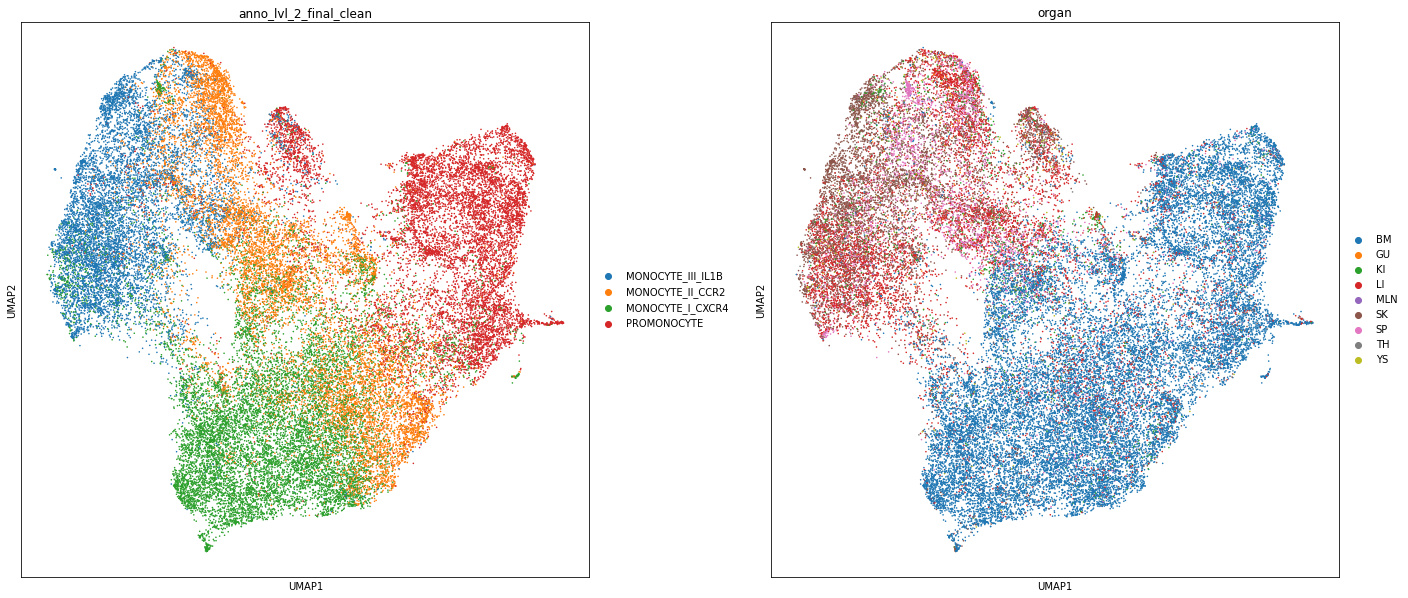

In [17]:
# sc.pl.umap(adata_mono_lognorm, color='anno_lvl_2_final_clean', show=False)
plt.rcParams['figure.figsize'] = [10,10]
sc.pl.umap(adata_mono_lognorm, color=['anno_lvl_2_final_clean', 'organ'], size=10, wspace=0.2)

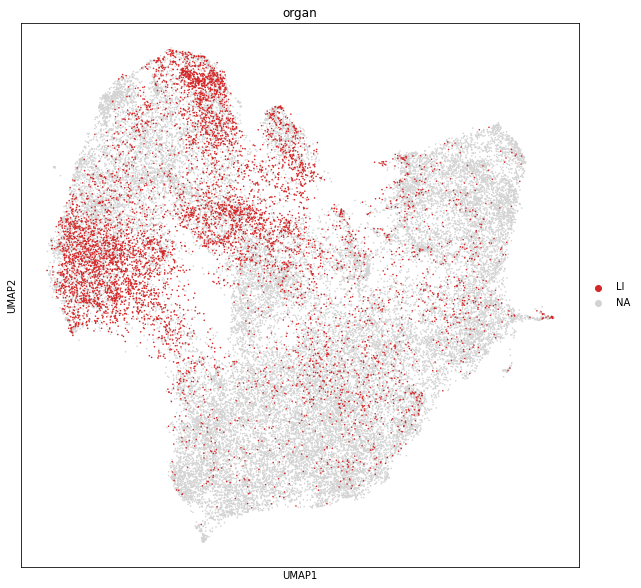

In [81]:
sc.pl.umap(adata_mono_lognorm, color=['organ'], size=10, wspace=0.2, groups=['LI'])

In [18]:
sc.tl.diffmap(adata_mono_lognorm, neighbors_key='scvi')

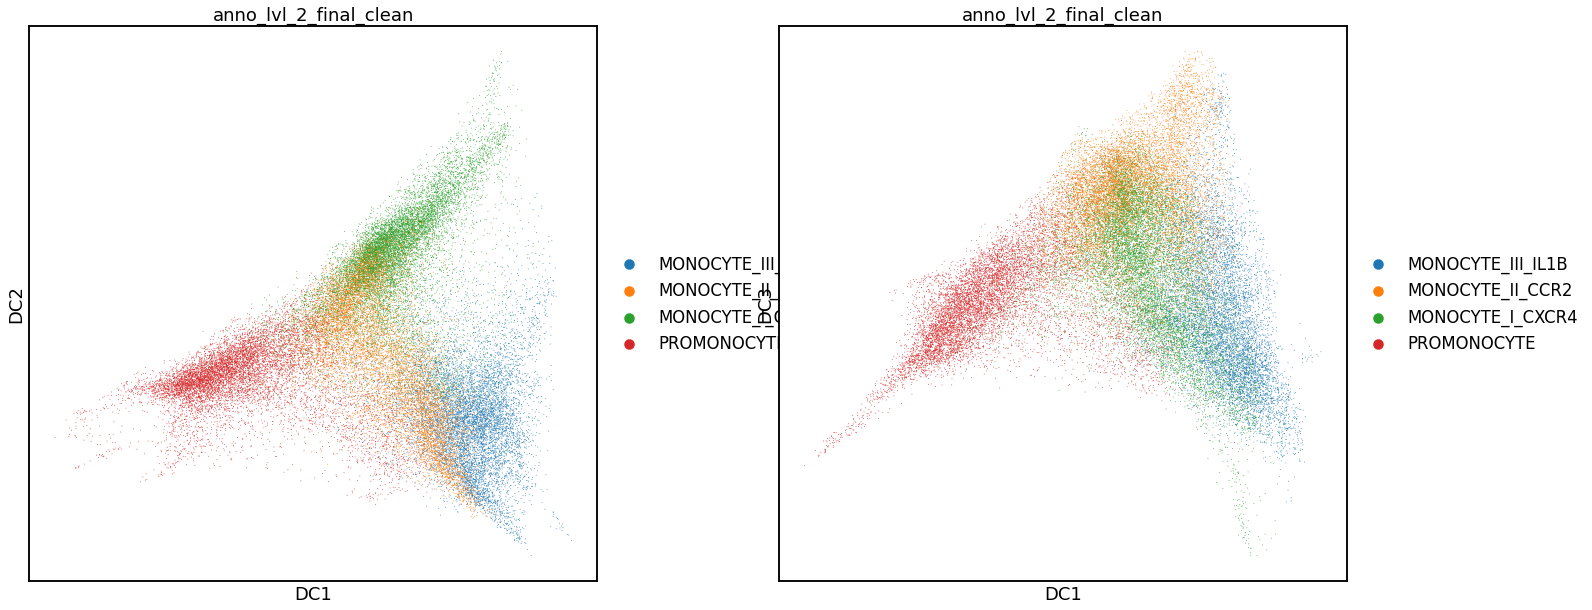

In [108]:
sc.pl.diffmap(adata_mono_lognorm, color='anno_lvl_2_final_clean', components=['1,2', '1,3'], ncols=2, wspace=0.2)

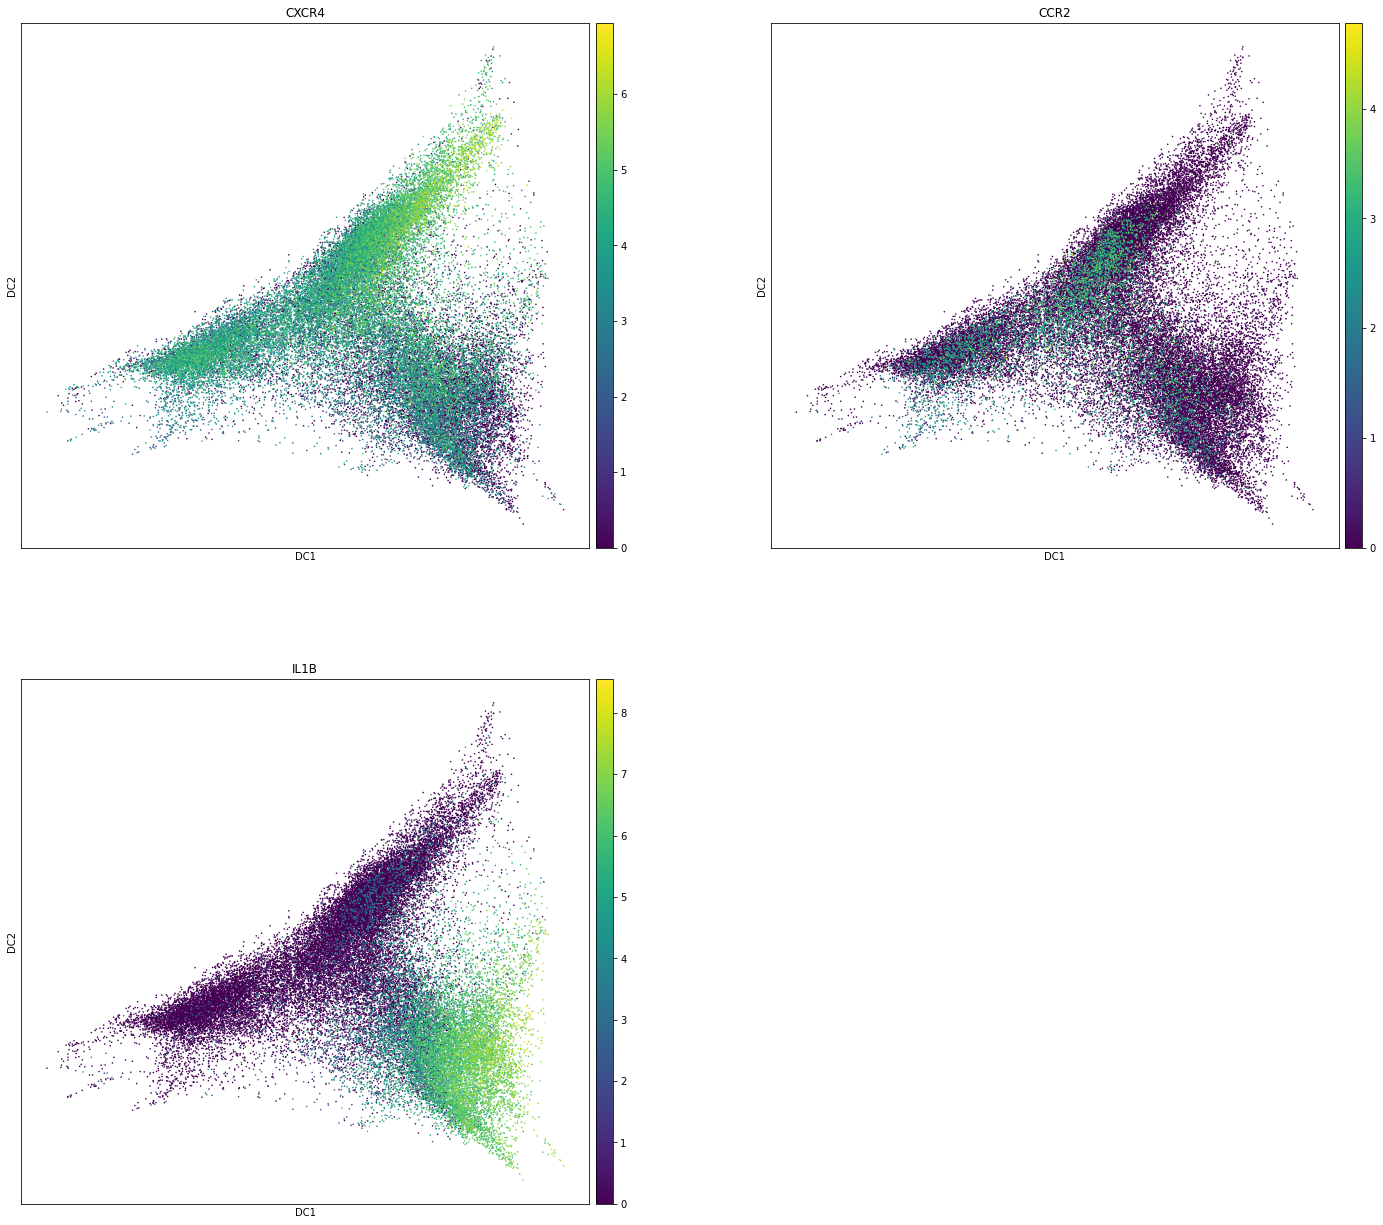

In [57]:
mono_markers = ['CXCR4', 'CCR2', "IL1B"]
sc.pl.diffmap(adata_mono_lognorm, color=mono_markers, components=['1,2'], ncols=2, wspace=0.2, size=10)

In [62]:
pl_adata =adata_mono_lognorm.copy()
pl_adata.obs['groups'] = pl_adata.obs['anno_lvl_2_final_clean'].astype('str') + "_" + pl_adata.obs['organ'].astype('str')
pl_adata.obs['groups'] = pl_adata.obs['groups'].astype('category')

pl_adata.obs['organ'] = pl_adata.obs['organ'].cat.reorder_categories(['YS', "LI", "BM", "TH", "SP", "MLN", "SK", "GU", "KI"])
pl_adata.obs['anno_lvl_2_final_clean'] = pl_adata.obs['anno_lvl_2_final_clean'].cat.reorder_categories(mono_annos)
gr_order = pl_adata.obs[['groups', 'organ', 'anno_lvl_2_final_clean']].sort_values(["organ", 'anno_lvl_2_final_clean'])['groups'].unique().astype('str')
pl_adata.obs['groups'] = pl_adata.obs['groups'].cat.reorder_categories(gr_order)

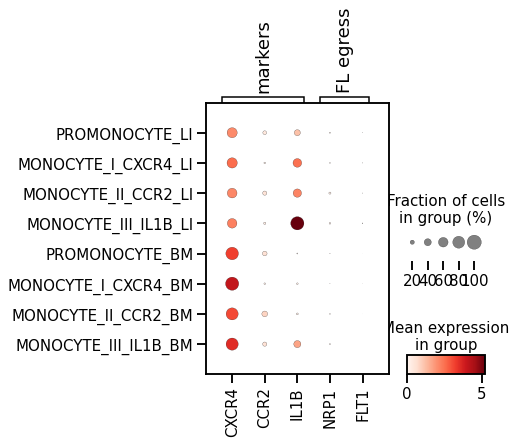

In [70]:
sns.set_context('talk')
sc.pl.dotplot(pl_adata[pl_adata.obs['organ'].isin(['BM', "LI"])], 
              {'markers':mono_markers,'FL egress':fli_egress_markers}, 
              groupby='groups', figsize=(5,5))

### Trajectory inference by organ

In [21]:
def compute_diffmap(adata_mono_lognorm):
    sc.pp.neighbors(adata_mono_lognorm, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")
    sc.tl.umap(adata_mono_lognorm, min_dist = 0.01, spread = 2, neighbors_key="scvi")
    sc.tl.diffmap(adata_mono_lognorm, neighbors_key='scvi')

In [22]:
adata_mono_li = adata_mono_lognorm[adata_mono_lognorm.obs['organ'] == 'LI'].copy()
adata_mono_bm = adata_mono_lognorm[adata_mono_lognorm.obs['organ'] == 'BM'].copy()

In [23]:
compute_diffmap(adata_mono_bm)
compute_diffmap(adata_mono_li)

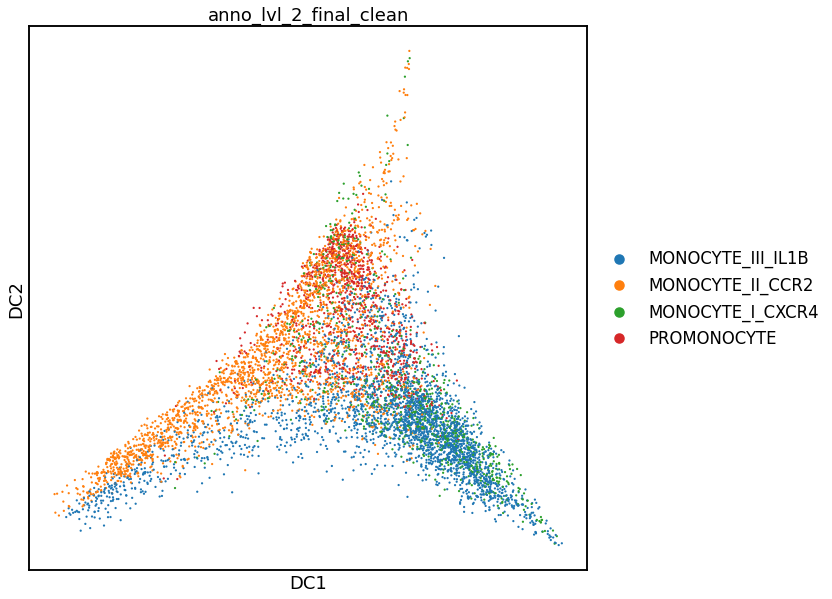

In [132]:
sc.pl.diffmap(adata_mono_li, color=['anno_lvl_2_final_clean'], components=['1,2'], ncols=2, wspace=0.2, size=20)

Find root cell based on expression of markers taken from Popescu et al (S100A9 high - CCL4/CD14 low for mono-pre cluster)

In [75]:
fli_promono_markers = ['S100A9', "CCL4", 'CD14']
fli_egress_markers = ['NRP1', 'FLT1']

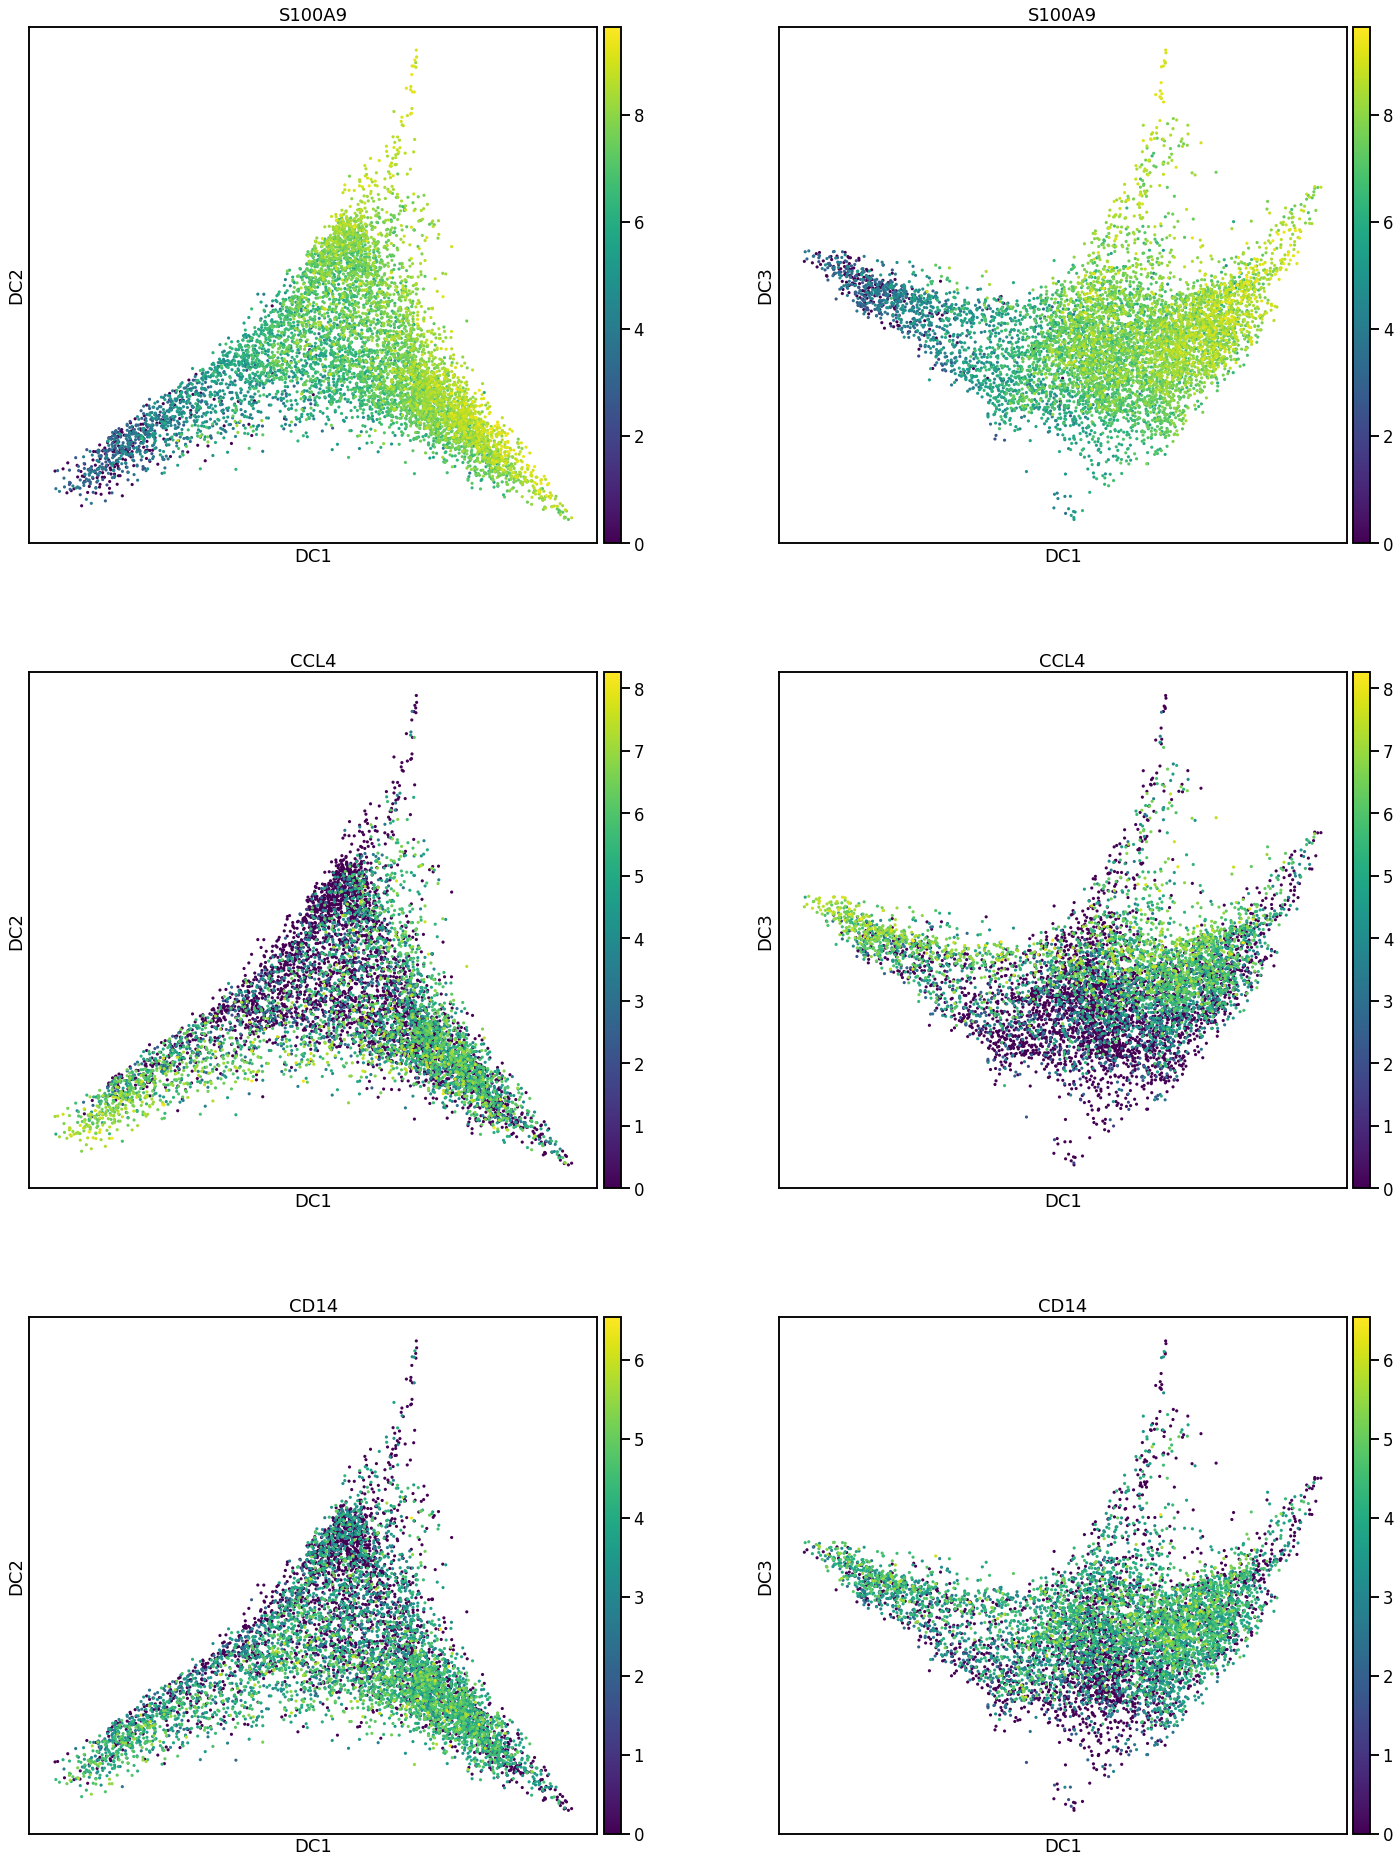

In [77]:
sc.pl.diffmap(adata_mono_li, color=fli_promono_markers, components=['1,2', '1,3'], ncols=2, wspace=0.2, size=40)

In [82]:
root_cell_index = adata_mono_li.obsm['X_diffmap'][:,2].argmax()
adata_mono_li.uns['iroot'] = root_cell_index
sc.tl.dpt(adata_mono_li, n_dcs=3, neighbors_key='scvi')

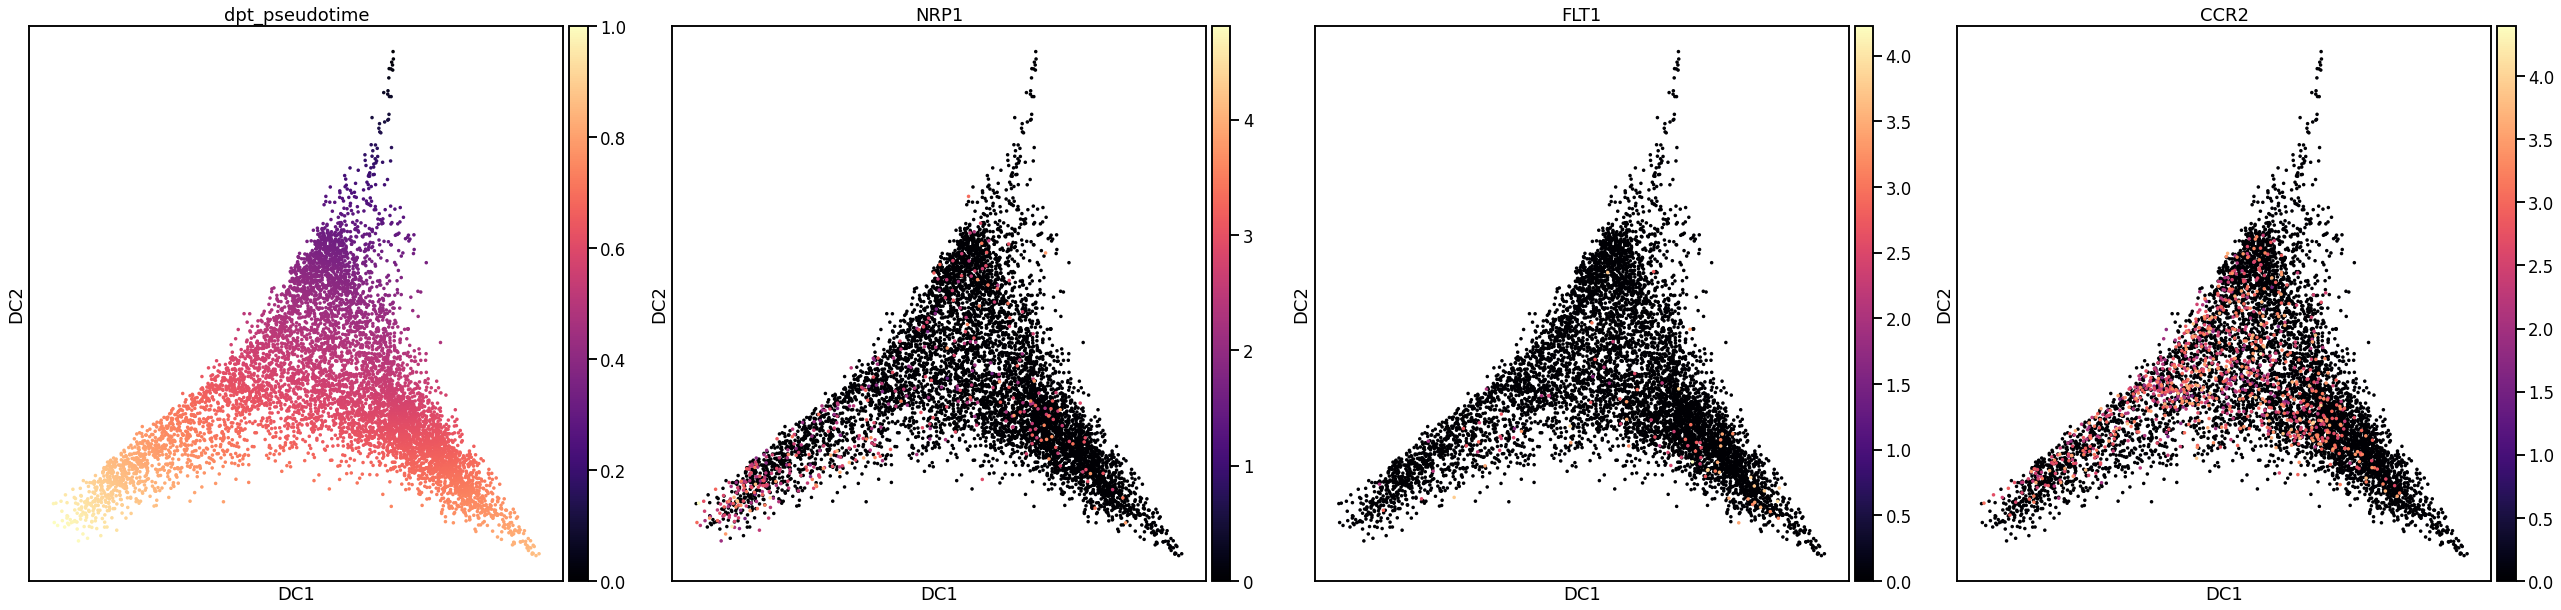

In [166]:
sc.pl.diffmap(adata_mono_li, color=['dpt_pseudotime'] + fli_egress_markers + ['CCR2'], size=50, cmap='magma')

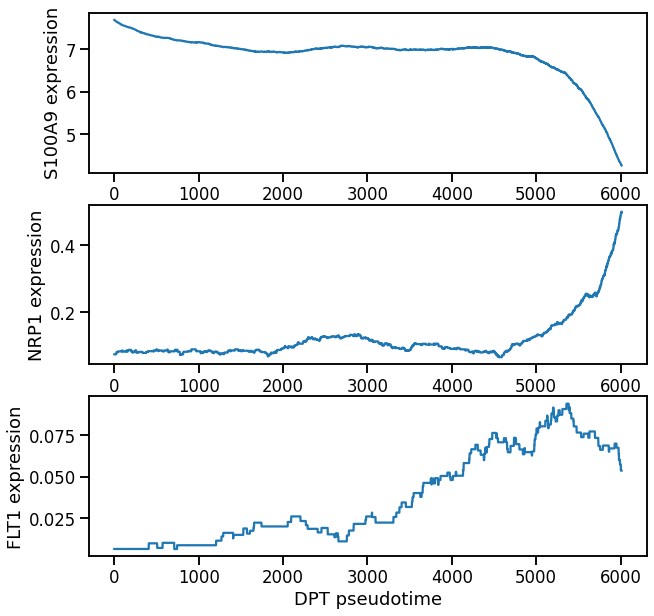

In [170]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

pl_genes = [fli_promono_markers[0]] + fli_egress_markers

order_obs = adata_mono_li.obs.sort_values('dpt_pseudotime').index
X_egress = adata_mono_li[order_obs,:][:, pl_genes].X.copy()
X_egress = X_egress.toarray()

for i, g in enumerate(pl_genes):
    plt.subplot(len(pl_genes),1,i+1)
    plt.plot(moving_average(X_egress[:,i], w=1000));
    plt.ylabel('{g} expression'.format(g=g));
# plt.subplot(3,1,2)
# plt.plot(moving_average(X_egress[:,1], w=1000));
# plt.ylabel('{g} expression'.format(g=fli_egress_markers[1]));
# plt.subplot(3,1,3)
# plt.plot(moving_average(X_egress[:,2], w=1000));
# plt.ylabel('{g} expression'.format(g='CCR2'));
plt.xlabel("DPT pseudotime");

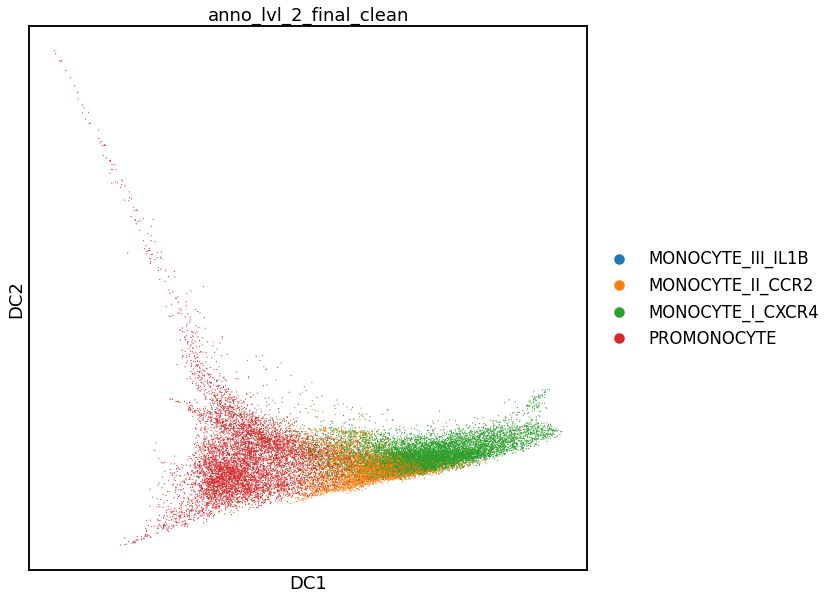

In [105]:
sc.pl.diffmap(adata_mono_bm, color=['anno_lvl_2_final_clean'], components=['1,2'], ncols=3, wspace=0.2)

In [186]:
root_cell_index = adata_mono_bm.obsm['X_diffmap'][:,2].argmax()
adata_mono_bm.uns['iroot'] = root_cell_index
sc.tl.dpt(adata_mono_bm, n_dcs=2, neighbors_key='scvi')

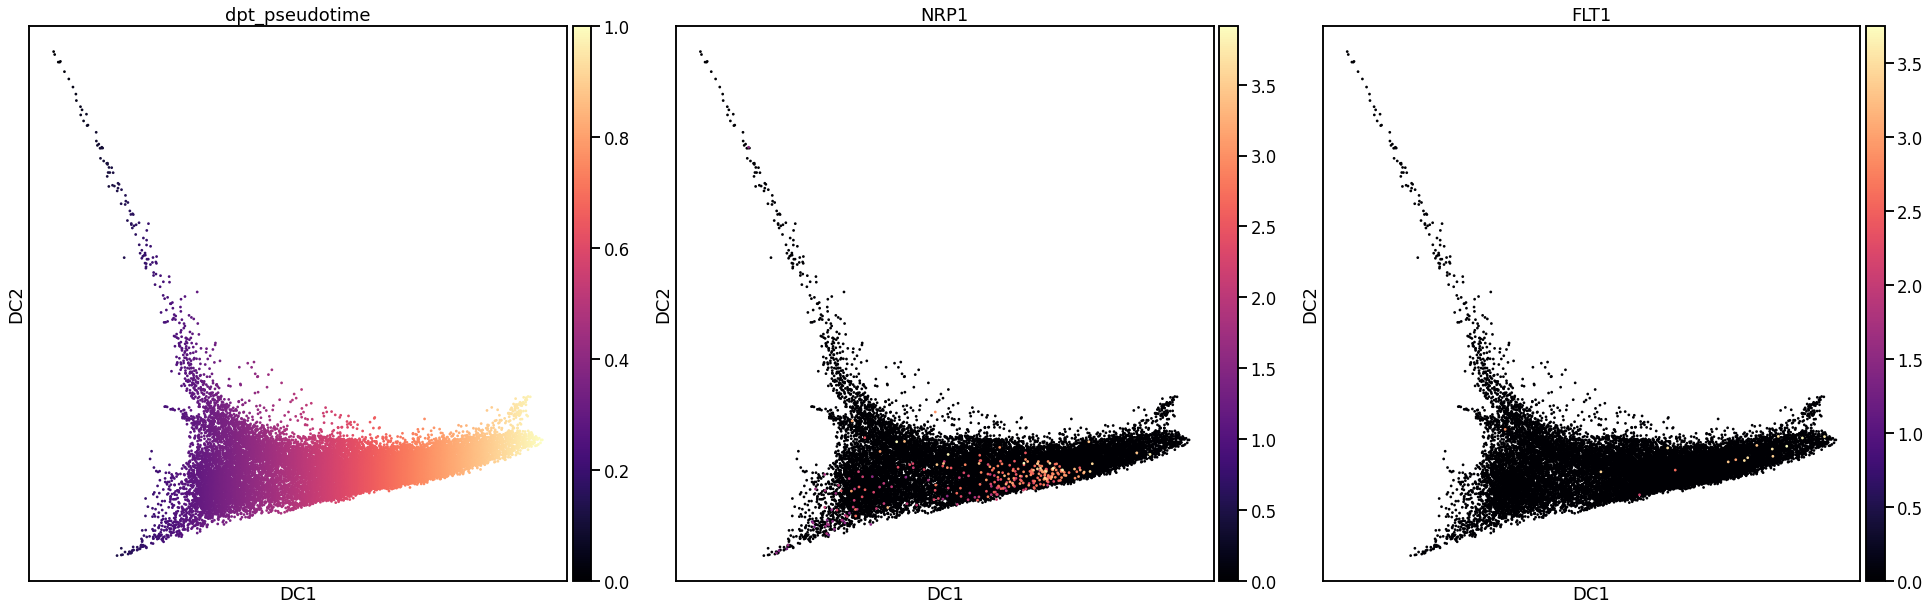

In [187]:
sc.pl.diffmap(adata_mono_bm, color=['dpt_pseudotime'], size=30, cmap='magma')

## Add liver and BM pseudotime to full object

In [188]:
adata_mono_lognorm.obs['Liver_DPT'] = np.nan
adata_mono_lognorm.obs.loc[adata_mono_li.obs_names, 'Liver_DPT'] = adata_mono_li.obs.dpt_pseudotime.copy()

adata_mono_lognorm.obs['BM_DPT'] = np.nan
adata_mono_lognorm.obs.loc[adata_mono_bm.obs_names, 'BM_DPT'] = adata_mono_bm.obs.dpt_pseudotime.copy()

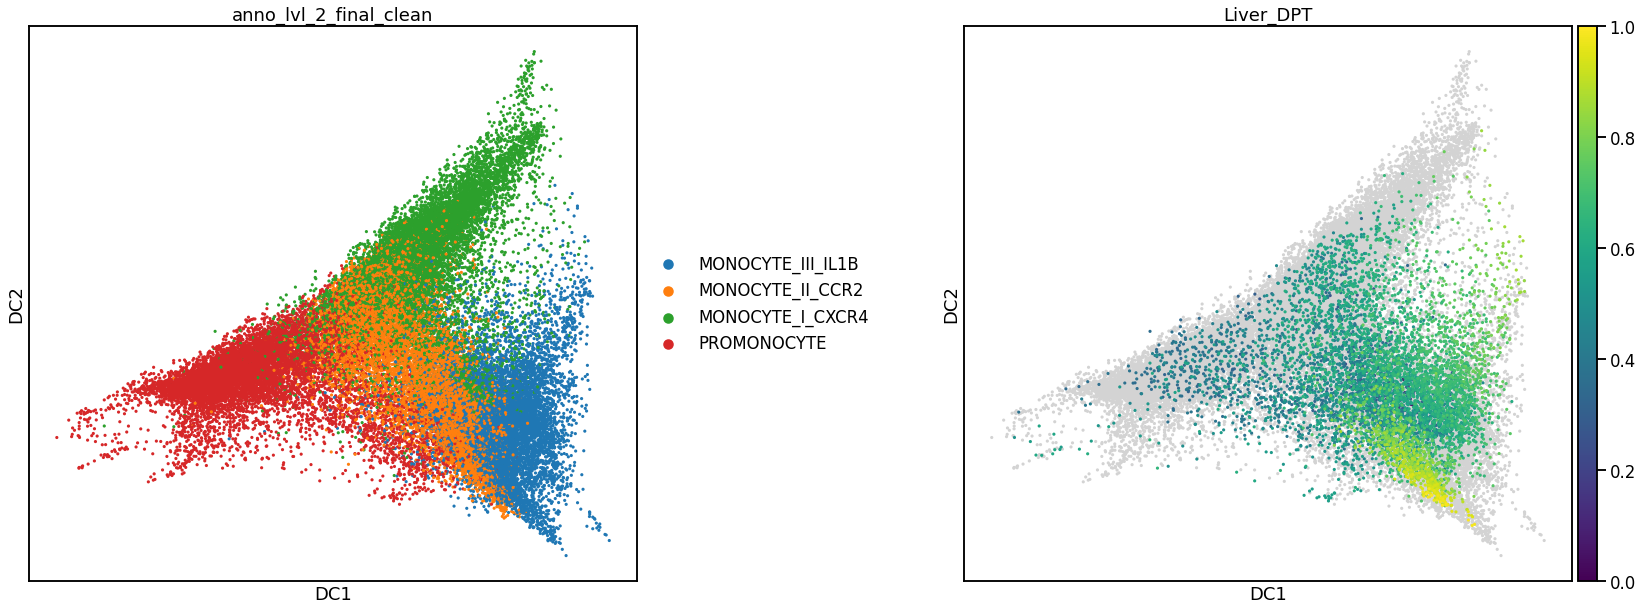

In [193]:
sc.pl.diffmap(adata_mono_lognorm, color=['anno_lvl_2_final_clean', 'Liver_DPT'], size=40, wspace=0.4)

In [195]:
adata_mono_lognorm.obs['predicted_doublets'] = adata_mono_lognorm.obs['predicted_doublets'].astype('bool')

In [196]:
adata_mono_lognorm.write_h5ad(data_dir+'monos.h5ad')

---

In [109]:
root_cell_index = adata_mono_lognorm.obsm['X_diffmap'][:,1].argmin()
adata_mono_lognorm.uns['iroot'] = root_cell_index
sc.tl.dpt(adata_mono_lognorm, neighbors_key='scvi', n_dcs=3)

adata_mono_lognorm.obs['dpt_order'] = adata_mono_lognorm.obs['dpt_pseudotime'].rank()

In [131]:
adata_mono_lognorm.obs.to_csv(data_dir +"monocytes_trajectory_analysis.csv")

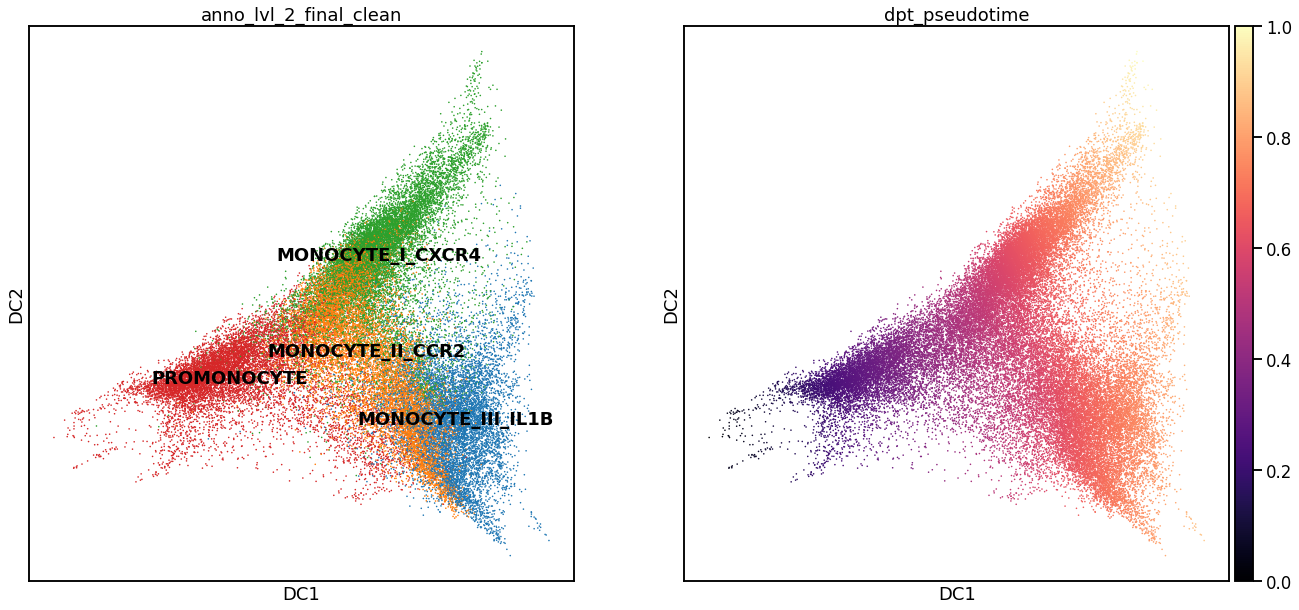

In [116]:
sc.pl.diffmap(adata_mono_lognorm, color=['anno_lvl_2_final_clean','dpt_pseudotime'], 
              legend_loc='on data',
              cmap='magma', size=10)

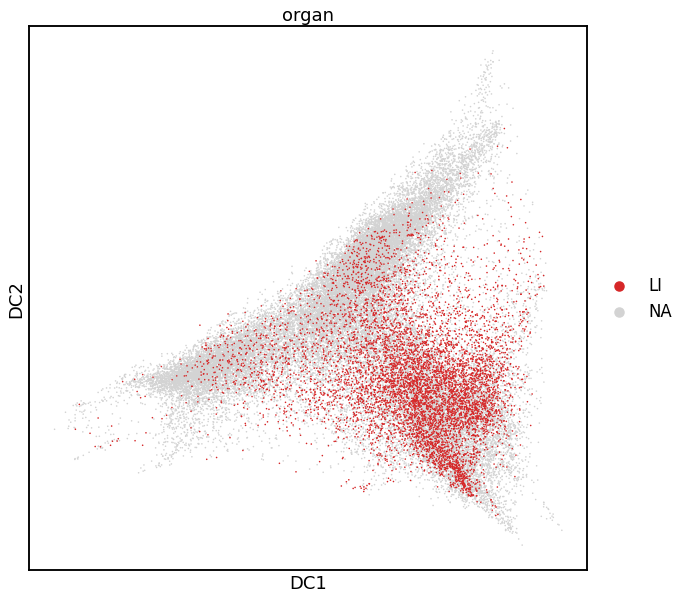

In [117]:
sc.pl.diffmap(adata_mono_lognorm, color=['organ'], groups=['LI'],
              cmap='magma', size=10)

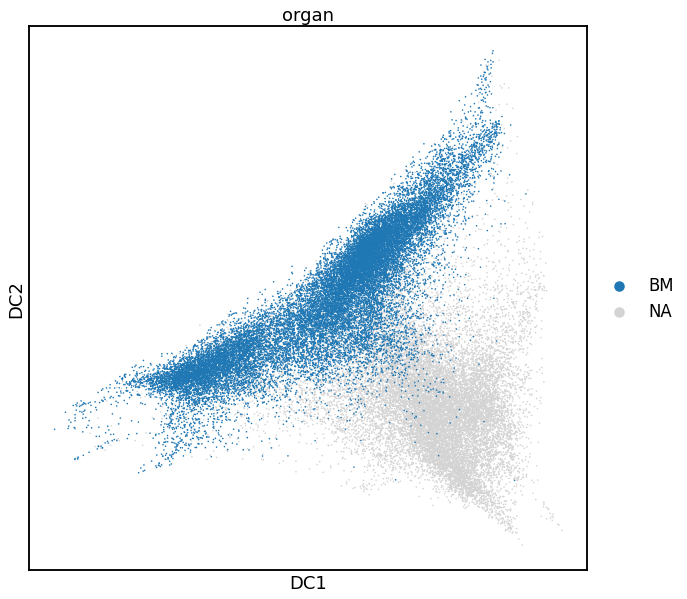

In [126]:
sc.pl.diffmap(adata_mono_lognorm, color=['organ'], groups=['BM'],
              cmap='magma', size=10)

In [130]:
X_egress.shape

(41083, 3)

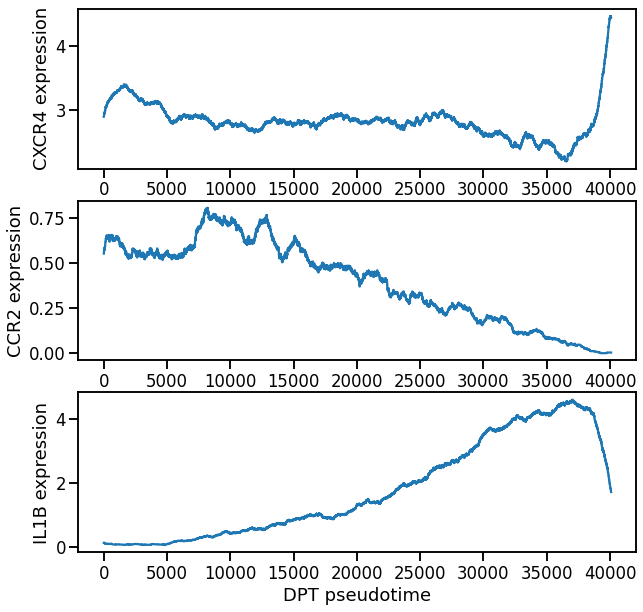

In [133]:
pl_adata = adata_mono_lognorm.copy()
order_obs = pl_adata.obs.sort_values('dpt_pseudotime').index
X_egress = pl_adata[order_obs,:][:,mono_markers].X.copy()
X_egress = X_egress.toarray()
plt.subplot(3,1,1)
plt.plot(moving_average(X_egress[:,0], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[0]));
plt.subplot(3,1,2)
plt.plot(moving_average(X_egress[:,1], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[1]));
plt.subplot(3,1,3)
plt.plot(moving_average(X_egress[:,2], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[2]));
plt.xlabel("DPT pseudotime");

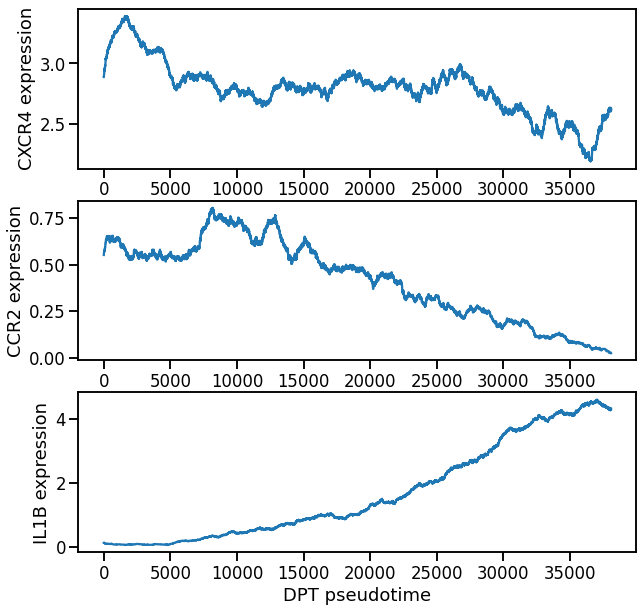

In [131]:
## Cutting out the end
order_obs = adata_mono_lognorm.obs.sort_values('dpt_pseudotime').index
X_egress = adata_mono_lognorm[order_obs[:-2000],:][:,mono_markers].X.copy()
X_egress = X_egress.toarray()
plt.subplot(3,1,1)
plt.plot(moving_average(X_egress[:,0], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[0]));
plt.subplot(3,1,2)
plt.plot(moving_average(X_egress[:,1], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[1]));
plt.subplot(3,1,3)
plt.plot(moving_average(X_egress[:,2], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[2]));
plt.xlabel("DPT pseudotime");

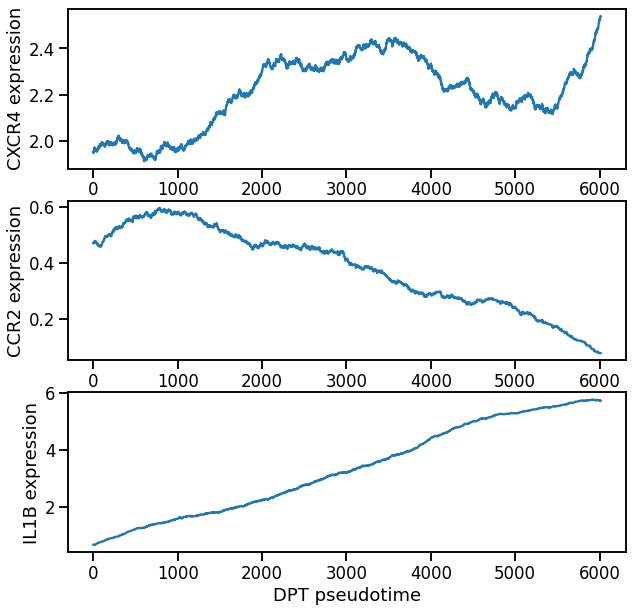

In [135]:
pl_adata = adata_mono_lognorm[adata_mono_lognorm.obs['organ'] == 'LI'].copy()
order_obs = pl_adata.obs.sort_values('dpt_pseudotime').index
X_egress = pl_adata[order_obs,:][:,mono_markers].X.copy()
X_egress = X_egress.toarray()
plt.subplot(3,1,1)
plt.plot(moving_average(X_egress[:,0], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[0]));
plt.subplot(3,1,2)
plt.plot(moving_average(X_egress[:,1], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[1]));
plt.subplot(3,1,3)
plt.plot(moving_average(X_egress[:,2], w=1000));
plt.ylabel('{g} expression'.format(g=mono_markers[2]));
plt.xlabel("DPT pseudotime");

In [112]:
df = adata_mono_lognorm.obs[['dpt_pseudotime', 'dpt_order','anno_lvl_2_final_clean', 'organ']]
mono_markers = ['CXCR4', "CCR2", "IL1B"]
marker_gex = adata_mono_lognorm[:, mono_markers].X.toarray()
marker_gex_df = pd.DataFrame(marker_gex, columns=mono_markers, index=adata_mono_lognorm.obs_names)
df = pd.concat([df,marker_gex_df ], 1)

/tmp/ipykernel_29176/4258397541.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df,marker_gex_df ], 1)


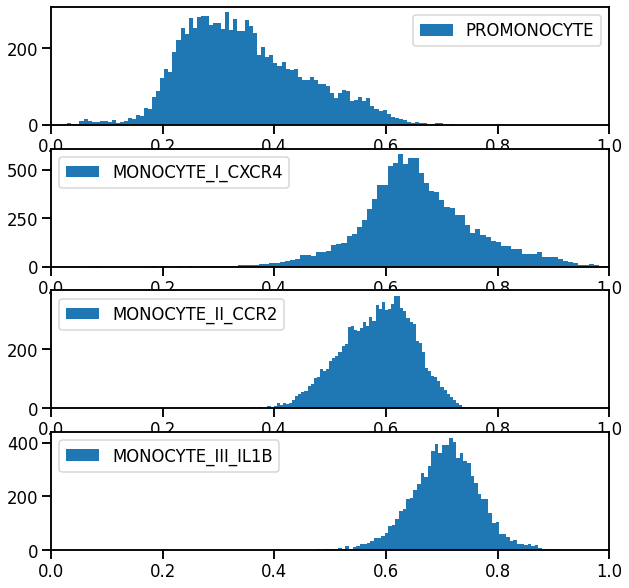

In [113]:
for i,a in enumerate(mono_annos):
    plt.subplot(4,1,i+1);
    plt.hist(df[df.anno_lvl_2_final_clean == a].dpt_pseudotime, bins=100, label=a);
    plt.xlim(0,1);
    plt.legend()

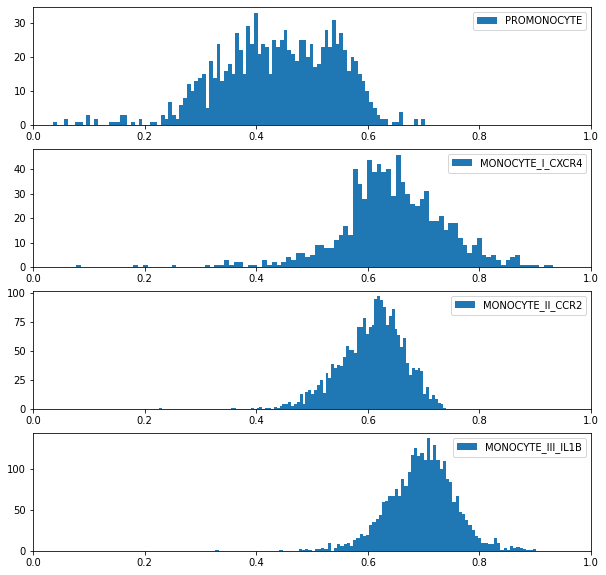

In [115]:
df_li = df[df.organ=='LI'].copy()
for i,a in enumerate(mono_annos):
    plt.subplot(4,1,i+1);
    plt.hist(df_li[df_li.anno_lvl_2_final_clean == a].dpt_pseudotime, bins=100, label=a);
    plt.xlim(0,1);
    plt.legend()

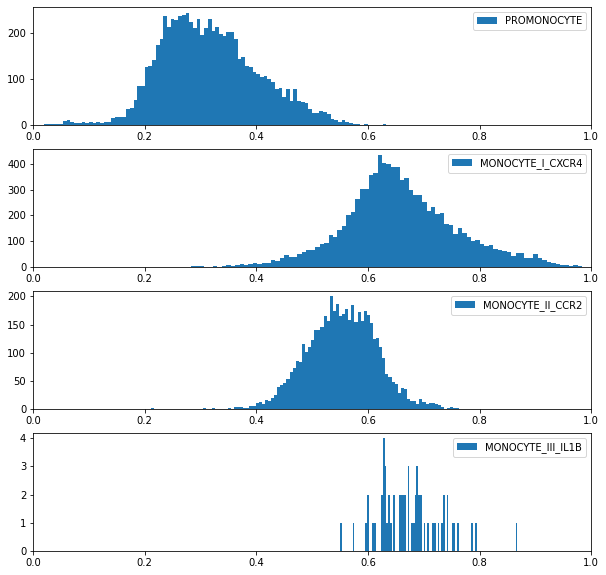

In [116]:
df_bm = df[df.organ=='BM'].copy()
for i,a in enumerate(mono_annos):
    plt.subplot(4,1,i+1);
    plt.hist(df_bm[df_bm.anno_lvl_2_final_clean == a].dpt_pseudotime, bins=100, label=a);
    plt.xlim(0,1);
    plt.legend()

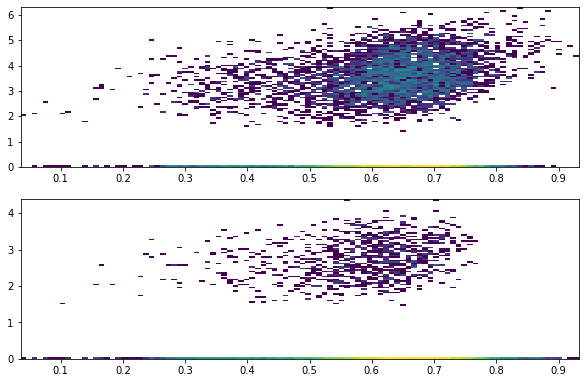

In [129]:
pl_df = df_li
plt.subplot(3,1,1)
plt.hist2d(pl_df.dpt_pseudotime,pl_df.CXCR4, norm=matplotlib.colors.LogNorm(), bins=100);
plt.subplot(3,1,2)
plt.hist2d(pl_df.dpt_pseudotime,pl_df.CCR2, norm=matplotlib.colors.LogNorm(), bins=100);

In [111]:
df = adata_mono_li.obs[['dpt_pseudotime','anno_lvl_2_final_clean', 'organ']]
mono_markers = ['CXCR4', "CCR2", "IL1B"]
marker_gex = adata_mono_li[:, mono_markers].X.toarray()
marker_gex_df = pd.DataFrame(marker_gex, columns=mono_markers, index=adata_mono_li.obs_names)
df = pd.concat([df,marker_gex_df ], 1)

/tmp/ipykernel_9640/1864040529.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df,marker_gex_df ], 1)


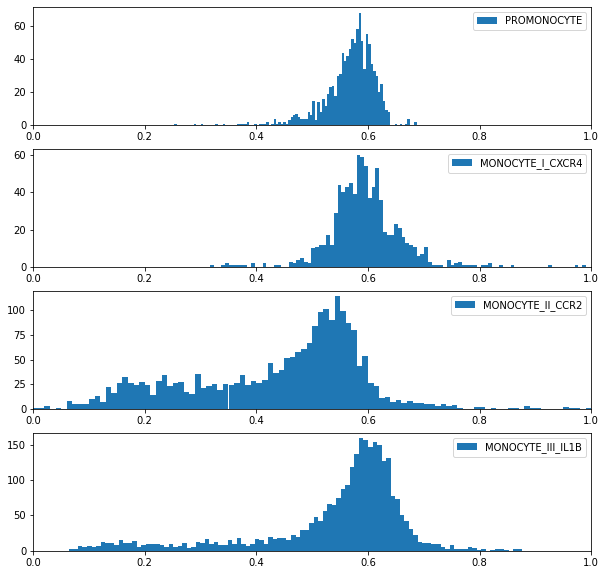

In [112]:
for i,a in enumerate(mono_annos):
    plt.subplot(4,1,i+1);
    plt.hist(df[df.anno_lvl_2_final_clean == a].dpt_pseudotime, bins=100, label=a);
    plt.xlim(0,1);
    plt.legend()

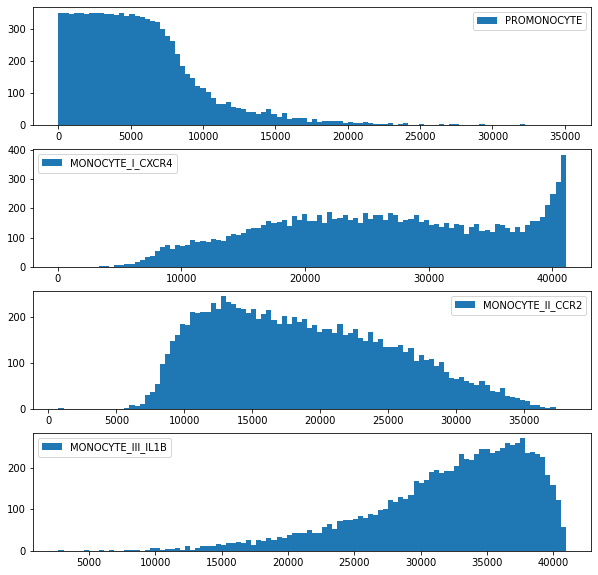

In [103]:
for i,a in enumerate(mono_annos):
    plt.subplot(4,1,i+1)
    plt.hist(df[df.anno_lvl_2_final_clean == a].dpt_order, bins=100, label=a)
    plt.legend()

---